In [1]:
# Cell 1: Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error
import warnings
from statsmodels.tools.sm_exceptions import EstimationWarning

# (tùy chọn) ẩn EstimationWarning (mình vẫn dùng optimized=False khi fit)
warnings.filterwarnings("ignore", category=EstimationWarning)


In [2]:
# Cell 2: Read data
df = pd.read_csv('Xiaomi_clean.csv')
df.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-07-09,16.6,17.000000,16.000000,16.799999,16.799999,462182642
1,2018-07-10,17.0,19.340000,17.000000,19.000000,19.000000,534072218
2,2018-07-11,18.5,19.799999,18.299999,19.000000,19.000000,374721138
3,2018-07-12,19.4,19.700001,19.020000,19.260000,19.260000,132592630
4,2018-07-13,19.6,21.799999,19.520000,21.450001,21.450001,364065075


In [3]:
# Cell 3: Reset index / Date handling (robust)
# strip column names
df.columns = df.columns.str.strip().str.replace('\ufeff','')

# If Date is an unnamed index column (saved previously), try loading index col:
if 'Date' not in df.columns and 'Unnamed: 0' in df.columns:
    # move Unnamed: 0 to Date
    df = df.rename(columns={'Unnamed: 0':'Date'})

# parse Date and drop rows that fail
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna(subset=['Date']).copy()
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

df.head()


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-07-09,16.6,17.000000,16.000000,16.799999,16.799999,462182642
2018-07-10,17.0,19.340000,17.000000,19.000000,19.000000,534072218
2018-07-11,18.5,19.799999,18.299999,19.000000,19.000000,374721138
2018-07-12,19.4,19.700001,19.020000,19.260000,19.260000,132592630
2018-07-13,19.6,21.799999,19.520000,21.450001,21.450001,364065075


In [4]:
# Cell 4: Select column 'Close' (same as mẫu)
df_Close = df[['Close']].copy()
df_Close.head()


,Close
Date,
2018-07-09,16.799999
2018-07-10,19.000000
2018-07-11,19.000000
2018-07-12,19.260000
2018-07-13,21.450001


In [5]:
# Cell 5: Min-max normalization
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(np.array(df_Close))
# ensure shape is (n,1)
data_scaled.shape


(1800, 1)

In [6]:
# Cell 6: Split data into Train:Validate:Test = 7:1:2
train_size = int(0.7 * len(data_scaled))
val_size   = int(0.1 * len(data_scaled))
test_size  = len(data_scaled) - train_size - val_size

train_data = data_scaled[:train_size]
val_data   = data_scaled[train_size: train_size + val_size]
test_data  = data_scaled[train_size + val_size : ]

train_size, val_size, test_size


(1260, 180, 360)

In [7]:
# Cell 7: Initialize trackers
best_alpha = None
best_mse = float('inf')
best_rmse = None
best_mape = None
best_msle = None
best_y_pred_val = None


In [8]:
# Cell 8: Training process - find best alpha (0.1 .. 0.9)
for alpha in np.arange(0.1, 1.0, 0.1):
    alpha = round(alpha, 1)
    # history should be 1-D array/list of scaled values
    history = train_data.reshape(-1).tolist()
    y_pred_val = []

    for obs in val_data:
        # build model on current history (1-D)
        model = SimpleExpSmoothing(history)
        # set optimized=False because smoothing_level fixed
        model_fit = model.fit(smoothing_level=alpha, optimized=False)
        pred = model_fit.forecast()[0]
        y_pred_val.append(pred)
        # append the actual next scaled observation into history
        history.append(float(obs.reshape(-1)[0]))

    # inverse transform before metrics
    val_inv = scaler.inverse_transform(val_data.reshape(-1,1))
    y_pred_val_inv = scaler.inverse_transform(np.array(y_pred_val).reshape(-1,1))

    mape = mean_absolute_percentage_error(val_inv, y_pred_val_inv)
    mse  = mean_squared_error(val_inv, y_pred_val_inv)
    rmse = np.sqrt(mse)
    msle = mean_squared_log_error(val_inv, y_pred_val_inv)

    if mse < best_mse:
        best_alpha = alpha
        best_mse = mse
        best_rmse = rmse
        best_mape = mape
        best_msle = msle
        best_y_pred_val = y_pred_val_inv

# print best alpha
print("Best alpha:", best_alpha)


Best alpha: 0.9


In [9]:
# Cell 9: Validation metrics
print(f"MAPE on Validate dataset: {best_mape}")
print(f"RMSE on Validate dataset: {best_rmse}")
print(f"MSLE on Validate dataset: {best_msle}")


MAPE on Validate dataset: 0.01968650661017945
RMSE on Validate dataset: 0.38014528852453433
MSLE on Validate dataset: 0.000601643637426522


In [10]:
# Cell 10: Testing process (iterative, same logic)
y_pred_test = []
# start history as train + val (scaled), flattened
history = np.concatenate([train_data, val_data], axis=0).reshape(-1).tolist()

for obs in test_data:
    model = SimpleExpSmoothing(history)
    model_fit = model.fit(smoothing_level=best_alpha, optimized=False)
    pred = model_fit.forecast()[0]
    y_pred_test.append(pred)
    # append the actual test scaled observation into history
    history.append(float(obs.reshape(-1)[0]))

# inverse transform
test_inv = scaler.inverse_transform(test_data.reshape(-1,1))
y_pred_test_inv = scaler.inverse_transform(np.array(y_pred_test).reshape(-1,1))


In [11]:
# Cell 11: Evaluate on test
test_mape = mean_absolute_percentage_error(test_inv, y_pred_test_inv)
test_mse  = mean_squared_error(test_inv, y_pred_test_inv)
test_rmse = np.sqrt(test_mse)
test_msle = mean_squared_log_error(test_inv, y_pred_test_inv)

print(f"MAPE on Test dataset: {test_mape}")
print(f"RMSE on Test dataset: {test_rmse}")
print(f"MSLE on Test dataset: {test_msle}")


MAPE on Test dataset: 0.021339144764458733
RMSE on Test dataset: 1.2160764601135308
MSLE on Test dataset: 0.0008177493367696304


In [12]:
# Cell 12: Prepare forecast date index (next 30 days)
last_date = df.index[-1]
next_date = last_date + pd.DateOffset(days=1)
index_next_30_days = pd.date_range(start=next_date, periods=30).tolist()
index_next_30_days[:3]  # preview


[Timestamp('2025-10-29 00:00:00'),
 Timestamp('2025-10-30 00:00:00'),
 Timestamp('2025-10-31 00:00:00')]

In [13]:
# Cell 13: Predict next 30 days using iterative one-step forecasts
y_next_30 = []
# start with full history (train + val + test), flattened scaled
history = np.concatenate([train_data, val_data, test_data], axis=0).reshape(-1).tolist()

for _ in range(30):
    model = SimpleExpSmoothing(history)
    model_fit = model.fit(smoothing_level=best_alpha, optimized=False)
    pred = model_fit.forecast()[0]
    y_next_30.append(pred)
    # append predicted scaled value into history for multi-step forecasts
    history.append(float(pred))

y_next_30_inv = scaler.inverse_transform(np.array(y_next_30).reshape(-1,1))
print("Predicted next 30 days (first 5):", y_next_30_inv.flatten()[:5])


Predicted next 30 days (first 5): [45.00998005 45.00998005 45.00998005 45.00998005 45.00998005]


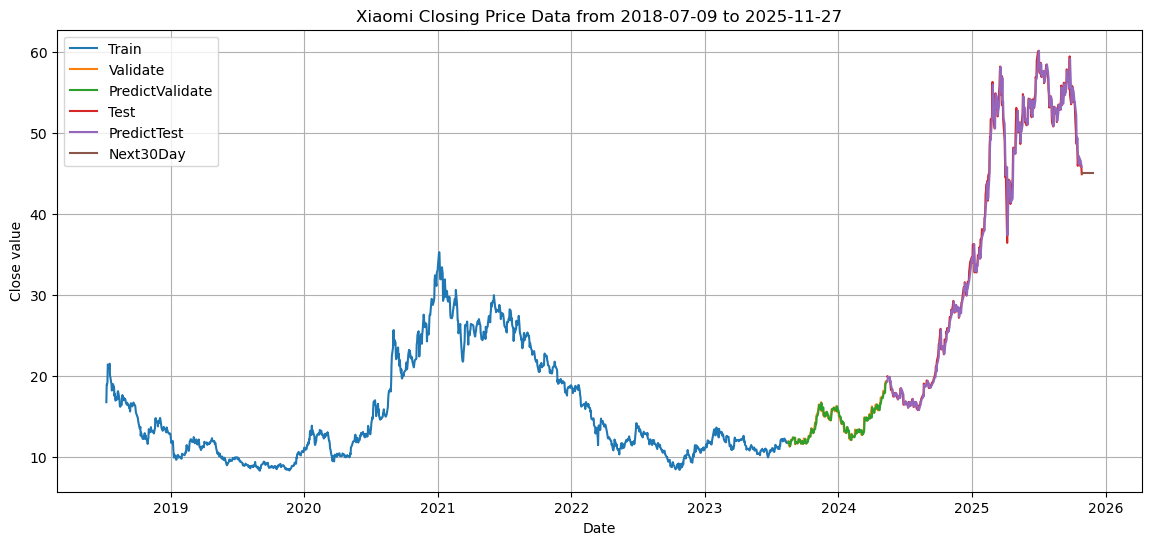

In [14]:
# Cell 14: Visualization - plot Train / Validate / PredictValidate / Test / PredictTest / Next30Day
plt.figure(figsize=(14,6))

# Train (inverse)
plt.plot(df.index[:train_size], scaler.inverse_transform(train_data), label='Train')

# Validate actual
plt.plot(df.index[train_size: train_size+val_size], scaler.inverse_transform(val_data), label='Validate')

# Validate predicted
plt.plot(df.index[train_size: train_size+val_size], best_y_pred_val, label='PredictValidate')

# Test actual
plt.plot(df.index[train_size+val_size:], scaler.inverse_transform(test_data), label='Test')

# Test predicted
plt.plot(df.index[train_size+val_size:], y_pred_test_inv, label='PredictTest')

# Next 30 days forecast
plt.plot(index_next_30_days, y_next_30_inv, label='Next30Day')

plt.legend()
plt.grid()
plt.xlabel('Date')
plt.ylabel('Close value')
plt.title(f"Xiaomi Closing Price Data from {df.index[0].strftime('%Y-%m-%d')} to {index_next_30_days[-1].strftime('%Y-%m-%d')}")
plt.savefig("ETS_712_Xiaomi.png", dpi=200, bbox_inches='tight')
plt.show()


In [15]:
# Cell 15: Save important outputs
# save forecast arrays to csv for reporting
pd.DataFrame({
    'test_date': df.index[train_size+val_size:],
    'test_actual': test_inv.flatten(),
    'test_predicted': y_pred_test_inv.flatten()
}).to_csv('Xiaomi_EST_test_results.csv', index=False)

pd.DataFrame({
    'forecast_date': index_next_30_days,
    'forecast_predicted': y_next_30_inv.flatten()
}).to_csv('Xiaomi_EST_next30.csv', index=False)

print("Saved: Xiaomi_EST_test_results.csv  and  Xiaomi_EST_next30.csv")
print(f"Best alpha: {best_alpha}")
print(f"Validate MAPE: {best_mape}, Test MAPE: {test_mape}")


Saved: Xiaomi_EST_test_results.csv  and  Xiaomi_EST_next30.csv
Best alpha: 0.9
Validate MAPE: 0.01968650661017945, Test MAPE: 0.021339144764458733
